In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.tree import export_graphviz
from sklearn.ensemble import AdaBoostClassifier
import graphviz
from IPython.display import Image, display
import warnings

import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
RANDOM_STATE = 42

In [6]:
df = pd.read_csv('/content/DataSetForPhishingVSBenignUrl.csv')
df.head()

,Querylength,domain_token_count,path_token_count,avgdomaintokenlen,longdomaintokenlen,avgpathtokenlen,tld,charcompvowels,charcompace,ldl_url,...,SymbolCount_FileName,SymbolCount_Extension,SymbolCount_Afterpath,Entropy_URL,Entropy_Domain,Entropy_DirectoryName,Entropy_Filename,Entropy_Extension,Entropy_Afterpath,URL_Type_obf_Type
0,0,4,5,5.5,14,4.400000,4,8,3,0,...,1,0,-1,0.726298,0.784493,0.894886,0.850608,NaN,-1.0,Defacement
1,0,4,5,5.5,14,6.000000,4,12,4,0,...,0,0,-1,0.688635,0.784493,0.814725,0.859793,0.0,-1.0,Defacement
2,0,4,5,5.5,14,5.800000,4,12,5,0,...,0,0,-1,0.695049,0.784493,0.814725,0.801880,0.0,-1.0,Defacement
3,0,4,12,5.5,14,5.500000,4,32,16,0,...,0,0,-1,0.640130,0.784493,0.814725,0.663210,0.0,-1.0,Defacement
4,0,4,6,5.5,14,7.333334,4,18,11,0,...,0,0,-1,0.681307,0.784493,0.814725,0.804526,0.0,-1.0,Defacement


In [7]:
df['URL_Type_obf_Type'].value_counts()

,count
URL_Type_obf_Type,
Defacement,7930
benign,7781
phishing,7586
malware,6712
spam,6698


In [8]:
le = LabelEncoder()
df['label'] = le.fit_transform(df['URL_Type_obf_Type'])

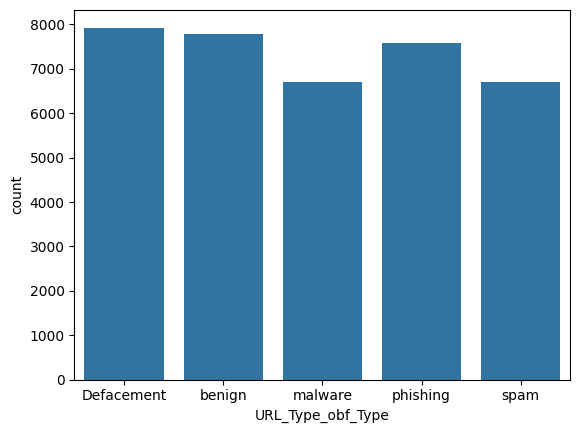

In [9]:
sns.countplot(x='URL_Type_obf_Type', data=df)
plt.show()

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36707 entries, 0 to 36706
Data columns (total 81 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Querylength                      36707 non-null  int64  
 1   domain_token_count               36707 non-null  int64  
 2   path_token_count                 36707 non-null  int64  
 3   avgdomaintokenlen                36707 non-null  float64
 4   longdomaintokenlen               36707 non-null  int64  
 5   avgpathtokenlen                  36427 non-null  float64
 6   tld                              36707 non-null  int64  
 7   charcompvowels                   36707 non-null  int64  
 8   charcompace                      36707 non-null  int64  
 9   ldl_url                          36707 non-null  int64  
 10  ldl_domain                       36707 non-null  int64  
 11  ldl_path                         36707 non-null  int64  
 12  ldl_filename      

In [11]:
df.isnull().sum()

,0
Querylength,0
domain_token_count,0
path_token_count,0
avgdomaintokenlen,0
longdomaintokenlen,0
...,...
Entropy_Filename,236
Entropy_Extension,40
Entropy_Afterpath,6
URL_Type_obf_Type,0


In [12]:
missing = df.isnull().sum()
missing_pct = (missing / len(df) * 100).sort_values(ascending=False)
missing_df =pd.concat([missing, missing_pct], axis=1, keys=['count','pct'])
missing_df.sort_values(by='count', ascending=False).head(10)

,count,pct
NumberRate_Extension,10130,27.596916
Entropy_DirectoryName,8468,23.069169
avgpathtokenlen,280,0.762797
Entropy_Filename,236,0.642929
Entropy_Extension,40,0.108971
NumberRate_FileName,10,0.027243
NumberRate_DirectoryName,10,0.027243
Entropy_Afterpath,6,0.016346
NumberRate_AfterPath,3,0.008173
Querylength,0,0.000000


In [13]:
corr = df.select_dtypes(include='number').corr()['label'].sort_values(ascending=False)
print(corr.head(10))

label                        1.000000
SymbolCount_Directoryname    0.329266
dld_url                      0.301209
dld_path                     0.301100
SymbolCount_Domain           0.294999
tld                          0.294414
domain_token_count           0.294414
URL_DigitCount               0.287118
Extension_DigitCount         0.283349
dld_getArg                   0.263688
Name: label, dtype: float64


In [14]:
# Due to low correlation, we can drop NumberRate_Extension and Entropy_DirectoryName columns
high_missing_cols = ['NumberRate_Extension', 'Entropy_DirectoryName']
df.drop(columns=high_missing_cols, inplace=True)

In [15]:
# Other columns with missing values have very low missing %, so fill with median
low_missing_cols = ['avgpathtokenlen', 'Entropy_Filename', 'Entropy_Extension', 'NumberRate_DirectoryName', 'NumberRate_FileName', 'Entropy_Afterpath', 'NumberRate_AfterPath', 'Querylength']
df[low_missing_cols] = df[low_missing_cols].fillna(df[low_missing_cols].median())

In [16]:
df.describe()

,Querylength,domain_token_count,path_token_count,avgdomaintokenlen,longdomaintokenlen,avgpathtokenlen,tld,charcompvowels,charcompace,ldl_url,...,SymbolCount_Directoryname,SymbolCount_FileName,SymbolCount_Extension,SymbolCount_Afterpath,Entropy_URL,Entropy_Domain,Entropy_Filename,Entropy_Extension,Entropy_Afterpath,label
count,36707.000000,36707.000000,36707.000000,36707.000000,36707.000000,36707.000000,36707.000000,36707.000000,36707.000000,36707.000000,...,36707.000000,36707.000000,36707.000000,36707.000000,36707.000000,36707.000000,36707.000000,36707.000000,36707.000000,36707.000000
mean,21.908110,2.857439,8.954668,5.401719,9.746016,4.552781,2.857439,14.976517,10.216117,3.363909,...,1.727545,3.600049,2.685237,1.903261,0.722350,0.842443,0.716280,0.508453,-0.209029,1.927562
std,94.280669,0.906562,4.278406,1.986858,4.856580,2.828816,0.906562,13.351315,10.845807,13.447289,...,2.719231,4.783213,4.557171,4.512421,0.048820,0.066251,0.410424,0.519463,0.891566,1.416854
min,0.000000,2.000000,0.000000,1.500000,2.000000,0.000000,2.000000,0.000000,0.000000,0.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,0.419560,0.561913,-1.000000,-1.000000,-1.000000,0.000000
25%,0.000000,2.000000,6.000000,4.000000,6.000000,3.000000,2.000000,7.000000,5.000000,0.000000,...,-1.000000,0.000000,0.000000,-1.000000,0.691929,0.795234,0.720302,0.000000,-1.000000,1.000000
50%,0.000000,3.000000,8.000000,5.000000,9.000000,4.100000,3.000000,13.000000,8.000000,0.000000,...,1.000000,1.000000,0.000000,-1.000000,0.723003,0.835752,0.785150,0.729292,-1.000000,2.000000
75%,19.000000,3.000000,11.000000,6.500000,12.000000,5.000000,3.000000,19.000000,12.000000,1.000000,...,3.000000,6.000000,4.000000,3.000000,0.754305,0.884735,0.884311,0.907449,0.758695,3.000000
max,1385.000000,19.000000,68.000000,29.500000,63.000000,105.000000,19.000000,193.000000,142.000000,207.000000,...,24.000000,40.000000,39.000000,40.000000,0.895403,1.000000,1.000000,1.000000,1.000000,4.000000


In [17]:
# columns with -inf and inf values
inf_cols = df.columns[(df == np.inf).any() | (df == -np.inf).any()]
print(inf_cols)

Index(['argPathRatio'], dtype='object')


In [18]:
# Fill nan in rows with inf values since only 10 rows have infinity
df = df.replace([np.inf, -np.inf], np.nan).dropna(subset=inf_cols)

In [19]:
X = df.drop(columns=['URL_Type_obf_Type', 'label'])
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)

In [20]:
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")
print(f"Train label distribution:\n{y_train.value_counts(normalize=True)}")
print(f"Test label distribution:\n{y_test.value_counts(normalize=True)}")

Train shape: (29357, 77), Test shape: (7340, 77)
Train label distribution:
label
0    0.216098
1    0.212045
3    0.206458
2    0.182887
4    0.182512
Name: proportion, dtype: float64
Test label distribution:
label
0    0.216076
1    0.211989
3    0.206540
2    0.182834
4    0.182561
Name: proportion, dtype: float64


In [21]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), X.columns)
    ]
)

In [23]:
depths = [1, 3, 6, 9, 12, 15, 18]
criterions = ['gini', 'entropy']
scores = {}

for depth in depths:
    for criterion in criterions:
        # create base estimator (decision tree with specified depth and criterion)
        base_estimator = DecisionTreeClassifier(
            max_depth=depth,
            criterion=criterion,
            random_state=RANDOM_STATE
        )

        # create AdaBoost classifier with the base estimator
        clf = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('classifier', AdaBoostClassifier(
                estimator=base_estimator,
                n_estimators=50,
                random_state=RANDOM_STATE
            ))
        ])

        # fit and predict
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)

        scores[(criterion, depth)] = accuracy

        print(f"\nAdaBoost with Decision Tree (criterion={criterion}, max_depth={depth})")
        print(f"Accuracy: {accuracy:.4f}")
        print("\nConfusion Matrix:")
        print(confusion_matrix(y_test, y_pred))
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred))
        print("-" * 70)


AdaBoost with Decision Tree (criterion=gini, max_depth=1)
Accuracy: 0.7027

Confusion Matrix:
[[1150  163   68  137   68]
 [   7 1370  128   32   19]
 [ 114  294  682  140  112]
 [  67  262  168  962   57]
 [ 204    1   38  103  994]]

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.73      0.74      1586
           1       0.66      0.88      0.75      1556
           2       0.63      0.51      0.56      1342
           3       0.70      0.63      0.67      1516
           4       0.80      0.74      0.77      1340

    accuracy                           0.70      7340
   macro avg       0.71      0.70      0.70      7340
weighted avg       0.70      0.70      0.70      7340

----------------------------------------------------------------------

AdaBoost with Decision Tree (criterion=entropy, max_depth=1)
Accuracy: 0.6817

Confusion Matrix:
[[1139  172   69   74  132]
 [  18 1387   80   37   34]
 [ 107  452  507  133  143

**Week 4 vs Week 7 Comparison**

In this analysis, we compared results from Week 4’s Decision Tree models and Week 7’s AdaBoost models to understand how boosting affects performance across different tree depths and criteria. Both sets of models were tested using the Gini and Entropy measures for splitting, and we focused on how model depth influences accuracy and generalization.

In Week 4, the standalone Decision Tree performed fairly modestly when the trees were shallow. At max_depth = 1, accuracy was only around 0.37, showing that the model was underfitting and mostly predicting majority classes. As we increased depth, performance improved — reaching around 0.70 accuracy by max_depth = 4. However, beyond that, the model’s improvement began to slow, and deeper trees risked overfitting the training data.

In Week 7, when we introduced AdaBoost using Decision Trees as the base estimator, the results improved dramatically — especially for shallow trees. With just max_depth = 1, AdaBoost already reached about 0.70 accuracy, compared to only 0.37 from Week 4. This shows how boosting combines multiple weak learners to form a much stronger model. As the trees got deeper, accuracy kept rising: around 0.85 at max_depth = 3, 0.95 at max_depth = 6, and eventually plateauing near 0.98 once the depth reached around 9 or higher.

The difference between Gini and Entropy criteria was minimal across all runs — both performed almost identically, with Gini being slightly faster computationally. What really mattered was the tree depth and whether boosting was applied.

Overall, the Week 7 AdaBoost results clearly outperform the Week 4 Decision Trees, especially at lower depths. Boosting helps reduce bias by focusing on the mistakes of earlier learners, turning weak models into a highly accurate ensemble. However, once the trees themselves become deep and complex, the additional benefit from AdaBoost becomes smaller. The best balance of accuracy and generalization was achieved with AdaBoost using tree depths between 6 and 9, reaching around 98% accuracy with well-balanced class predictions.

**Advantage of Adaboost**

AdaBoost does offer an advantage, but it depends on the situation. When using shallow trees, AdaBoost really shines by combining many weak learners into a powerful model that generalizes well. However, as the trees get deeper, this benefit starts to fade. Once the individual trees become strong enough to capture complex patterns on their own, AdaBoost doesn’t add much extra value. In fact, beyond a depth of around 9, both models tend to level off in performance, suggesting that the dataset is already close to being fully separable at that point.

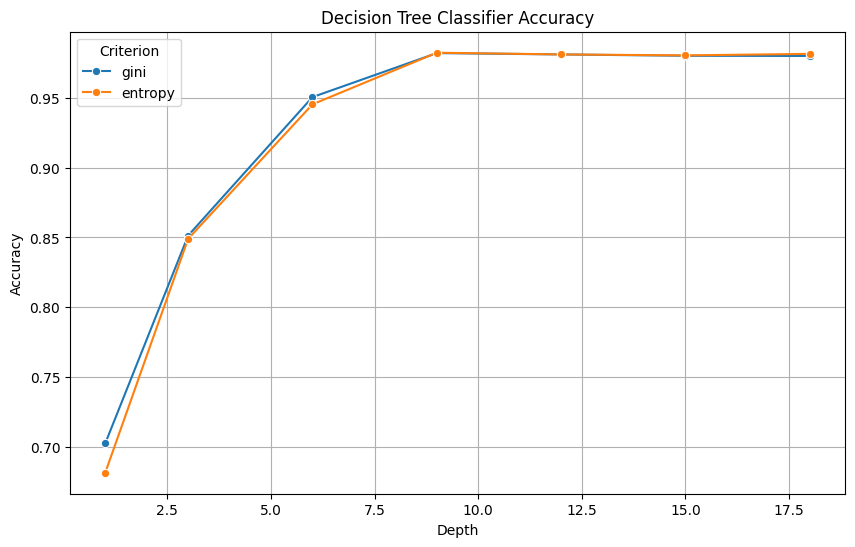

In [24]:
# plot accuracies
plt.figure(figsize=(10, 6))

sns.lineplot(x=[depth for _, depth in scores.keys()], y=scores.values(), hue=[criterion for criterion, _ in scores.keys()], marker='o')
plt.title('Decision Tree Classifier Accuracy')
plt.xlabel('Depth')
plt.ylabel('Accuracy')
plt.legend(title='Criterion')
plt.grid()
plt.show()

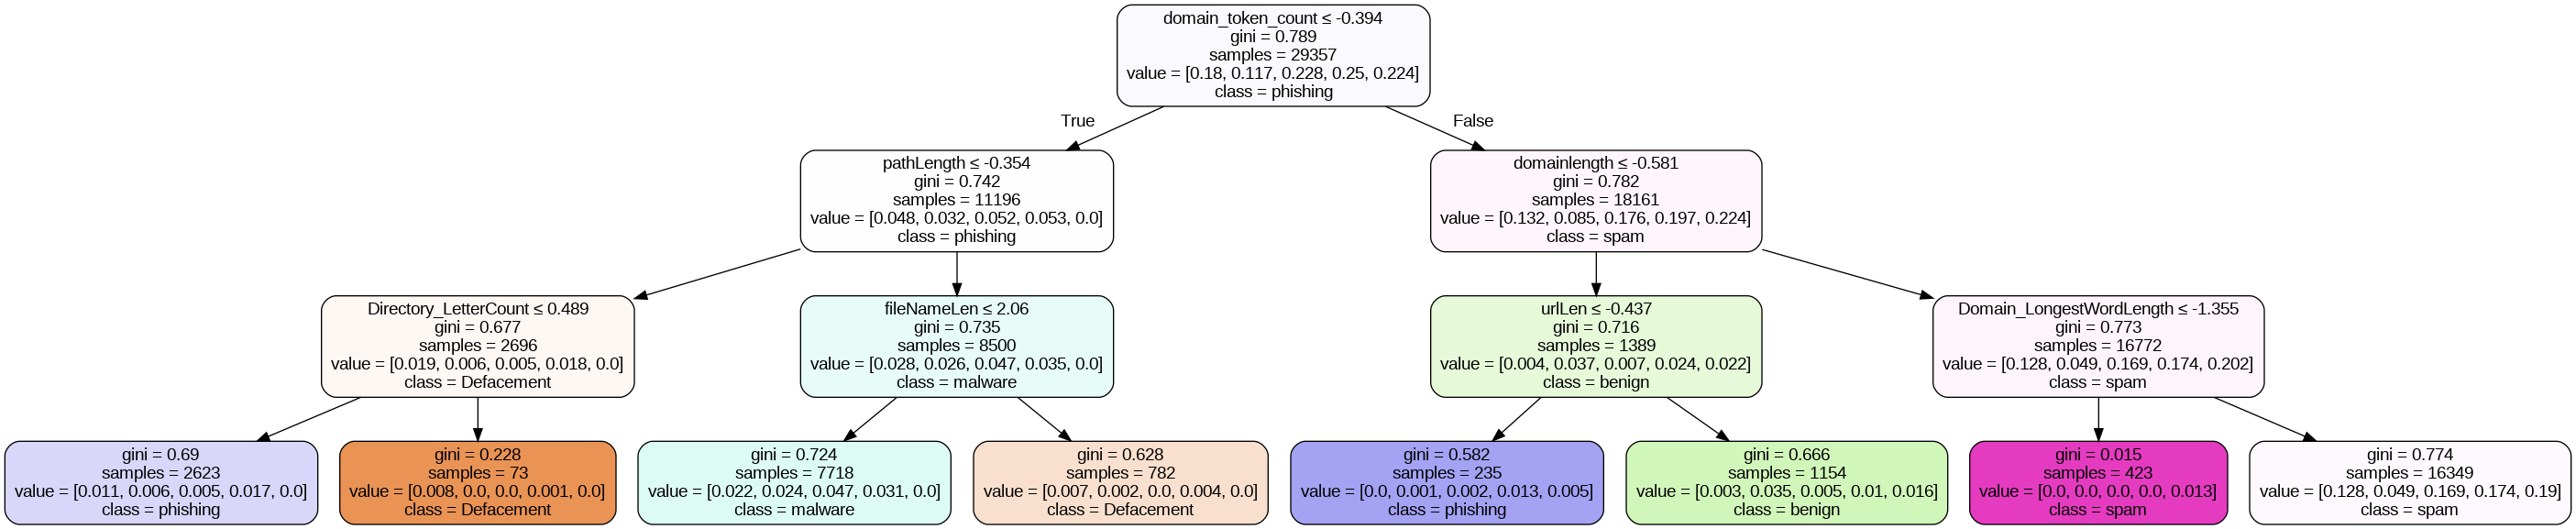

In [28]:
small_depth = 3
small_criterion = 'gini'

small_base = DecisionTreeClassifier(
    max_depth=small_depth,
    criterion=small_criterion,
    random_state=RANDOM_STATE
)
small_clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', AdaBoostClassifier(
        estimator=small_base,
        n_estimators=50,
        random_state=RANDOM_STATE
    ))
])
small_clf.fit(X_train, y_train)

small_tree = small_clf.named_steps['classifier'].estimators_[-1]

dot_data = export_graphviz(
    small_tree,
    out_file=None,
    feature_names=X_train.columns,
    class_names=le.classes_,
    filled=True,
    rounded=True,
    special_characters=True
)
graph = graphviz.Source(dot_data)
graph.render("adaboost_small_tree", format='png', cleanup=True)
display(Image(filename='adaboost_small_tree.png'))